# [Introduction to modeling and simulation of human movement](https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md)
## Task for lecture 16
### Problem:
Find out the combination of dorsiflexor/plantar flexor activations to keep the ankle joint at five degrees of dorsiflexion.

### Result:
It turned out that I was unable to find the optimal combination of excitations for agonist/antagonist pairs by trial an error. I presented the results, including the joint angle, at the results section.

In [27]:
# Preparing the environment
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import math
import sys
funcPath = './../functions/'
sys.path.insert(1, funcPath)  # add to pythonpath
from Muscle import Muscle

Parameters from Thelen (2003) and Elias (2014)

In [28]:
# Muscle parameters from Thelen (2003)
# Dorsiflexors
Lslack_DF = 2.4*0.09 # tendon slack length
Lce_o_DF  = 0.09 # optimal muscle fiber length
Fmax_DF   = 1400 #maximal isometric DF force
alpha_DF  = 7*math.pi/180 # DF muscle fiber pennation angle

# Soleus
#Lslack_PF = np.mean([0.03,0.05,0.031])*np.mean([8.8,8.3,10]) # tendon slack length
#Lce_o_PF  = np.mean([0.03,0.05,0.031]) # optimal muscle fiber length
#alpha_PF  = np.mean([25,14,12])*math.pi/180 # DF muscle fiber pennation angle

Lslack_PF = 8.8*0.03 # tendon slack length
Lce_o_PF  = 0.03 # optimal muscle fiber length
Fmax_PF   = 3150 + 1750 + 3150 #maximal isometric DF force
alpha_PF  = 25*math.pi/180 # DF muscle fiber pennation angle

In [29]:
dt = 0.0001 #step time

In [30]:
dorsiflexors  = Muscle(Lce_o=Lce_o_DF, Fmax=Fmax_DF, Lslack=Lslack_DF, 
                       alpha=alpha_DF, dt=dt)
plantarflexors= Muscle(Lce_o=Lce_o_PF, Fmax=Fmax_PF, Lslack=Lslack_PF, 
                       alpha=alpha_PF, dt=dt)

### Muscle properties

Activation dynamics parameters

In [31]:
a = 1
u = 1 #Initial conditional for Brain's activation
#b = .25*10#*Lce_o 

### Subject's anthropometrics
Parameters obtained experimentally or from Winter's book.

In [32]:
M      = 75 #total body mass (kg)
Lseg   = 0.26 #segment length (m)
m      = 0.0145*M #foot mass (kg)
g      = 9.81 #acceleration of gravity (m/s2)
Rcm    = Lseg*0.5 #distance from ankle joint to center of mass (m)
I      = m*(0.69*Lseg)**2 #moment of inertia
legAng = math.pi/2 #angle of the leg with horizontal (90 deg)

### Coefficients for the calculation of the moment arm and length of the muscles according to Elias et al (2014).

In [33]:
As_TA = np.array([30.6, -7.44e-2, -1.41e-4, 2.42e-6, 1.5e-8]) / 100   # at [m] instead of [cm]
As_SOL= np.array([32.3, 7.22e-2, -2.24e-4, -3.15e-6, 9.27e-9]) / 100   # at [m] instead of [cm]
# Coefs for moment arm for ankle angle
Bs_TA = np.array([4.3, 1.66e-2, -3.89e-4, -4.45e-6, -4.34e-8]) / 100  # at [m] instead of [cm]
Bs_SOL= np.array([-4.1, 2.57e-2, 5.45e-4, -2.22e-6, -5.5e-9]) / 100  # at [m] instead of [cm]

### Initial conditions

In [34]:
phi = 0
phid = 0 #zero velocity
Lm0_DF  = 0.29 #initial total lenght of the muscle
Lm0_SOL = 0.29 #initial total lenght of the muscle
#dorsiflexors.Lnorm_ce  = 0.087/dorsiflexors.Lce_o #norm
#plantarflexors.Lnorm_ce= 0.025/plantarflexors.Lce_o #norm # CONFIGURE INITIAL LENGTH OF SOLEUS

dorsiflexors.Lnorm_ce  = ((Lm0_DF-Lslack_DF)/np.cos(alpha_DF))/Lce_o_DF #accounting for pennation angle
plantarflexors.Lnorm_ce= ((Lm0_SOL-Lslack_PF)/np.cos(alpha_PF))/Lce_o_PF
t0 = 0 #Initial time
tf = 0.5 #Final Time

In [35]:
t = np.arange(t0,tf,dt) # time array
# preallocating
F          = np.empty(shape=(t.shape[0],2))
phivec     = np.empty(shape=(t.shape[0],2))
Fkpe       = np.empty(shape=(t.shape[0],2))
FiberLen   = np.empty(shape=(t.shape[0],2))
TendonLen  = np.empty(shape=(t.shape[0],2))
a_dynamics = np.empty(shape=(t.shape[0],2))
a_dynamics = np.empty(shape=(t.shape[0],2))
Moment     = np.empty(shape=(t.shape[0],2))
Rarm       = np.empty(shape=(t.shape[0],2))
MomentNET  = np.empty(t.shape)
Lnorm_see  = np.empty(t.shape)

## Simulation - Series

In [36]:
def ComputeMomentJoint(Rf_TA, Fnorm_tendon_TA, Fmax_TA, Rf_SOL, Fnorm_tendon_SOL, Fmax_SOL, m, g, phi):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    M = Rf_TA*Fnorm_tendon_TA*Fmax_TA - m*g*Rcm*np.sin(legAng - phi) + Rf_SOL*Fnorm_tendon_SOL*Fmax_SOL
    return M

In [37]:
def ComputeMomentJointTA(Rf_TA, Fnorm_tendon_TA, Fmax_TA, m, g, phi):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    M_TA = Rf_TA*Fnorm_tendon_TA*Fmax_TA - m*g*Rcm*np.sin(legAng - phi)
    return M_TA

In [38]:
def ComputeMomentJointSOL(Rf_SOL, Fnorm_tendon_SOL, Fmax_SOL, m, g, phi):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    M_SOL = Rf_SOL*Fnorm_tendon_SOL*Fmax_SOL - m*g*Rcm*np.sin(legAng - phi)
    return M_SOL

In [39]:
def ComputeAngularAcelerationJoint(M, I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

In [40]:
def computeMomentArmJoint(theta, Bs):
    # theta - joint angle (degrees)
    # Bs - coeficients for the polinomio

    auxBmultp = np.empty(Bs.shape);
    for i in range (len(Bs)):
        auxBmultp[i] = Bs[i] * (theta**i)

    Rf = sum(auxBmultp)

    return Rf

In [41]:
def ComputeTotalLenghtSize(theta, As):
        # theta = joint angle(degrees)
        # As - coeficients for the polinomio

        auxAmultp = np.empty(As.shape);

        for i in range (len(As)):
            auxAmultp[i] = As[i] * (theta**i)

        Lm = sum(auxAmultp)

        return Lm

# Simulation

In [42]:
for i in range (len(t)):
    Lm_TA = ComputeTotalLenghtSize(phi*180/np.pi, As_TA)
    Rf_TA = computeMomentArmJoint(phi*180/np.pi, Bs_TA)

    Lm_SOL = ComputeTotalLenghtSize(phi*180/np.pi, As_SOL)
    Rf_SOL = computeMomentArmJoint(phi*180/np.pi, Bs_SOL)
    ##############################################################
    dorsiflexors.updateMuscle(Lm=Lm_TA, u=0.8)
    plantarflexors.updateMuscle(Lm=Lm_SOL, u=0.17)
    #####################################################################     
    #Compute MomentJoint
    M = ComputeMomentJoint(Rf_TA,dorsiflexors.Fnorm_tendon,dorsiflexors.Fmax,
                           Rf_SOL,plantarflexors.Fnorm_tendon,plantarflexors.Fmax,
                           m,g,phi)
    M_TA = ComputeMomentJointTA(Rf_TA,dorsiflexors.Fnorm_tendon,dorsiflexors.Fmax,
                           m,g,phi)
    M_SOL= ComputeMomentJointTA(Rf_SOL,plantarflexors.Fnorm_tendon,plantarflexors.Fmax,
                           m,g,phi)
    #Compute Angular Aceleration Joint
    phidd = ComputeAngularAcelerationJoint (M,I)
    # Euler integration steps
    phid= phid + dt*phidd
    phi  = phi  + dt*phid
    phideg= (phi*180)/math.pi #convert joint angle from radians to degree
    # Store variables in vectors
    F[i,:] = np.array([dorsiflexors.Fnorm_tendon*dorsiflexors.Fmax,plantarflexors.Fnorm_tendon*plantarflexors.Fmax])
    Fkpe[i,:] = np.array([dorsiflexors.Fnorm_kpe*dorsiflexors.Fmax,plantarflexors.Fnorm_kpe*plantarflexors.Fmax])
    FiberLen[i,:] = np.array([dorsiflexors.Lnorm_ce*dorsiflexors.Lce_o,plantarflexors.Lnorm_ce*plantarflexors.Lce_o])
    TendonLen[i,:] = np.array([dorsiflexors.Lnorm_see*dorsiflexors.Lce_o,plantarflexors.Lnorm_see*plantarflexors.Lce_o])
    a_dynamics[i,:] = np.array([dorsiflexors.a,plantarflexors.a])
    phivec[i] = phideg,
    MomentNET[i] = M
    Moment[i,:] = np.array([M_TA,M_SOL])
    Rarm[i,:] = np.array([Rf_TA,Rf_SOL])
    
    
    Lnorm_see[i] = plantarflexors.tendonLength(Lm=Lm_SOL)

## Results
Activation dynamics

<IPython.core.display.Javascript object>


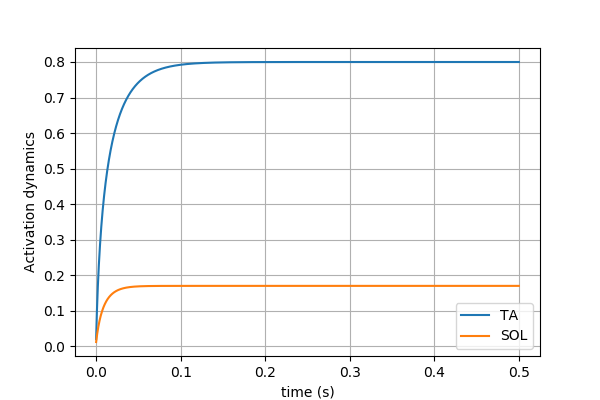

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t,a_dynamics)
ax.legend(['TA','SOL'])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics')
plt.show()

Ankle angle

<IPython.core.display.Javascript object>


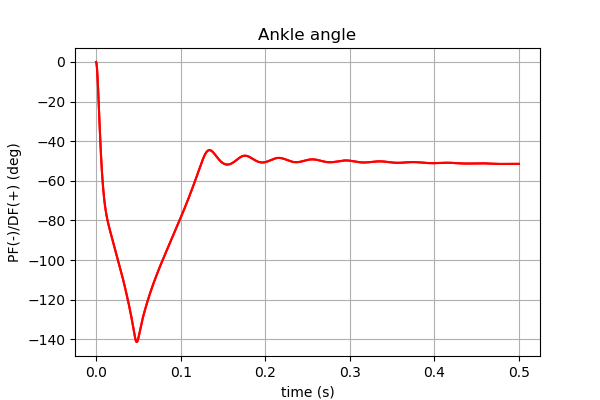

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(t,phivec,c='red')
plt.grid()
plt.title('Ankle angle')
plt.xlabel('time (s)')
plt.ylabel('PF(-)/DF(+) (deg)')
plt.show()

Ankle moments

<IPython.core.display.Javascript object>


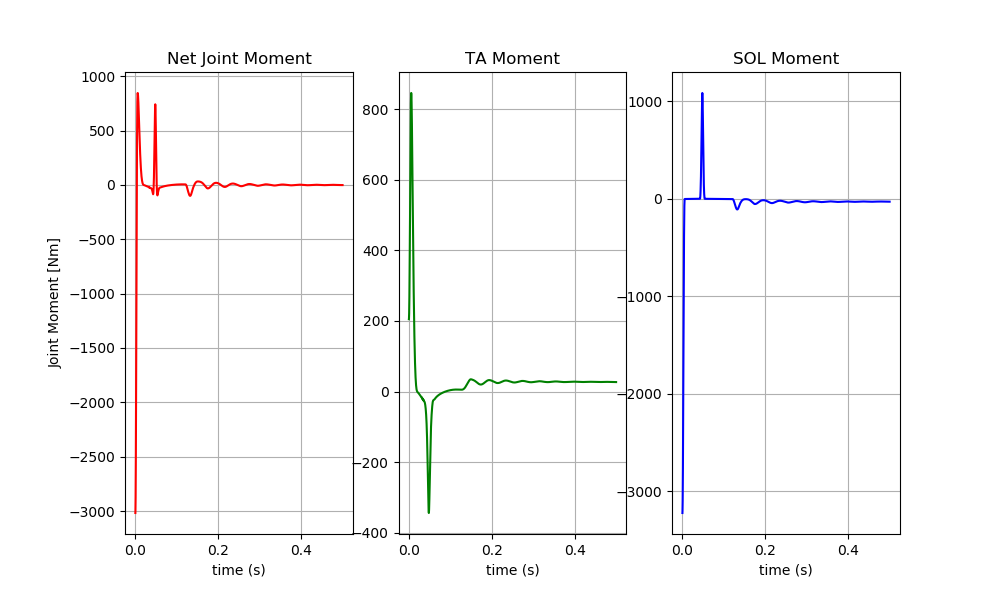

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(10,6))
ax[0].plot(t,MomentNET,'r')
ax[0].set_ylabel('Joint Moment [Nm]')
ax[0].set_xlabel('time (s)')
ax[0].set_title('Net Joint Moment')
ax[0].grid()
ax[1].plot(t,Moment[:,0],'g')
ax[1].set_xlabel('time (s)')
ax[1].set_title('TA Moment')
ax[1].grid()
ax[2].plot(t,Moment[:,1],'b')
ax[2].set_xlabel('time (s)')
ax[2].set_title('SOL Moment')
ax[2].grid()
plt.show()

Moment arm

<IPython.core.display.Javascript object>


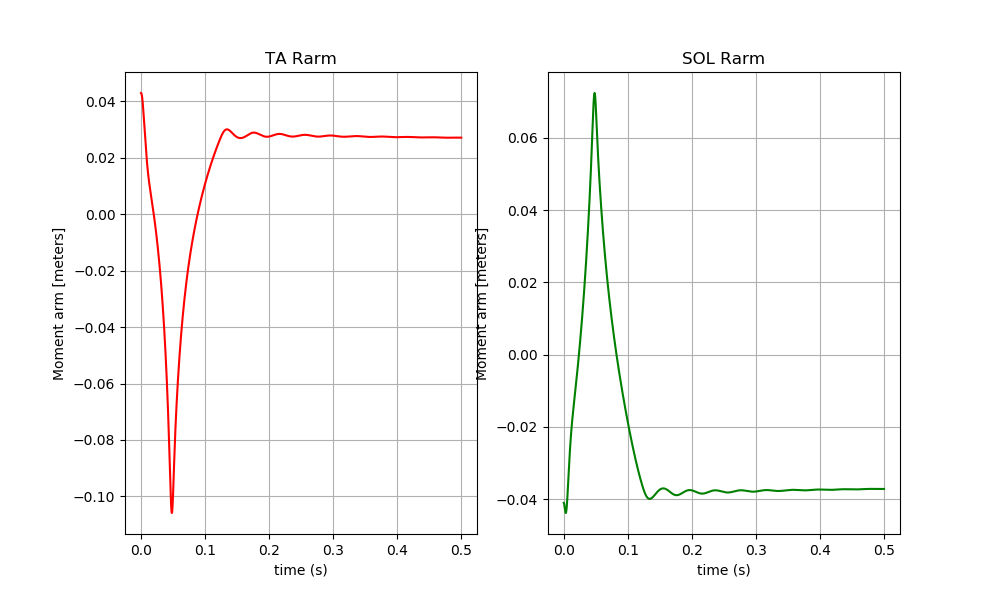

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].plot(t,Rarm[:,0],'r')
ax[0].set_xlabel('time (s)')
ax[0].set_title('TA Rarm')
ax[0].set_ylabel('Moment arm [meters]')
ax[0].grid()
ax[1].plot(t,Rarm[:,1],'g')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Moment arm [meters]')
ax[1].set_title('SOL Rarm')
ax[1].grid()
plt.show()

Tendon forces

<IPython.core.display.Javascript object>


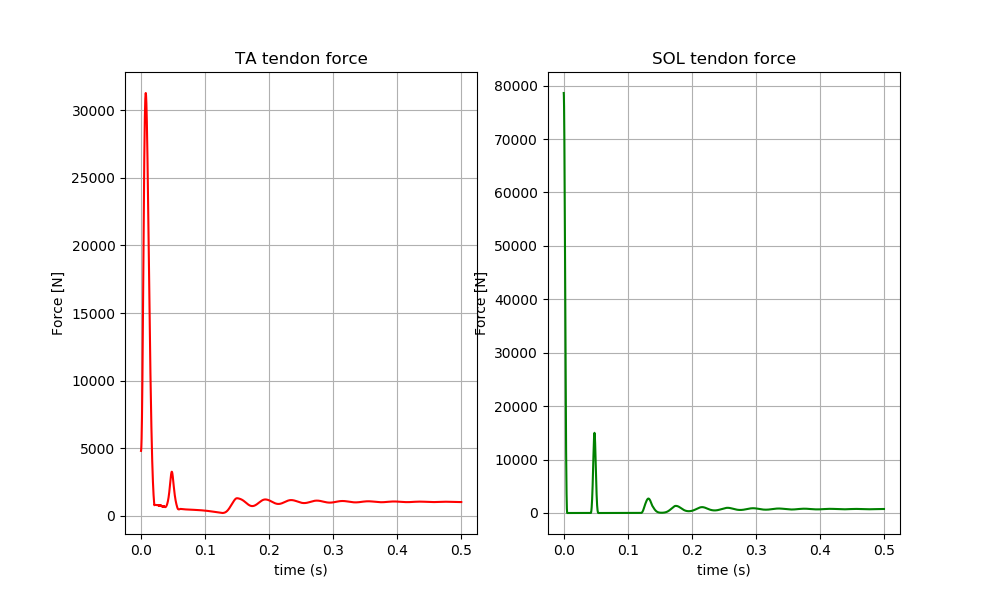

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].plot(t, F[:,0], 'r')
ax[0].set_xlabel('time (s)')
ax[0].set_title('TA tendon force')
ax[0].set_ylabel('Force [N]')
ax[0].grid()
ax[1].plot(t, F[:,1], 'g')
ax[1].set_xlabel('time (s)')
ax[1].set_title('SOL tendon force')
ax[1].set_ylabel('Force [N]')
ax[1].grid()
plt.show()

<IPython.core.display.Javascript object>


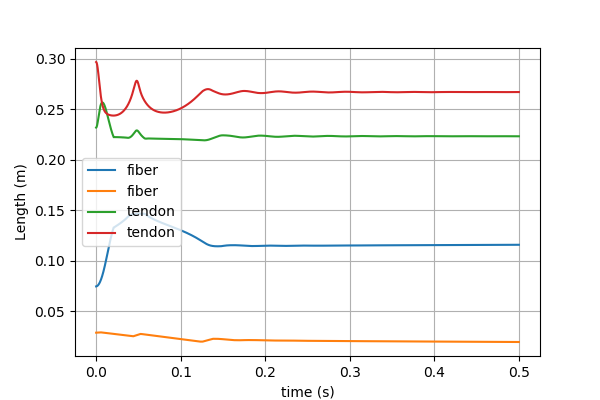

<IPython.core.display.Javascript object>


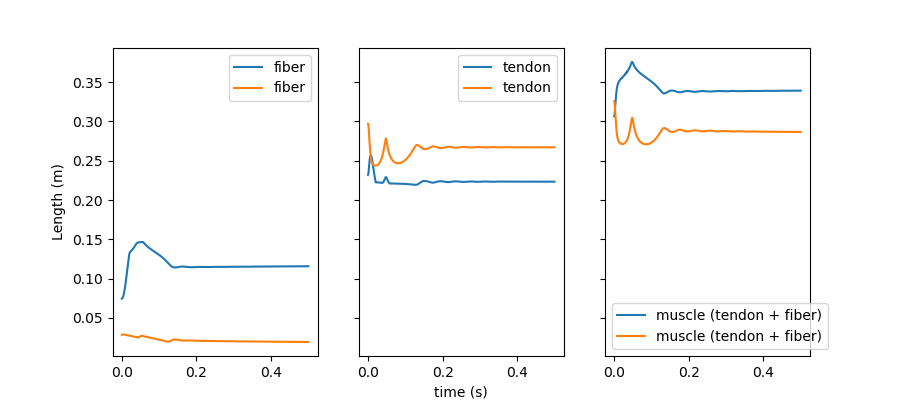

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')
plt.show()

In [49]:
import numpy as np
class Muscle:
    
    def __init__(self, Lslack, Lce_o, Fmax, alpha, dt):
        
        self.Lslack = Lslack # tendon slack length
        self.Lce_o  = Lce_o # optimal muscle fiber length
        self.Fmax   = Fmax #maximal isometric DF force
        self.alpha  = alpha # DF muscle fiber pennation angle
        
        
        self.UmaxTendon = 0.04
        self.Umax = 1
        self.width = 0.63 # Max relative length change of CE
        self.FMlen = 1.4 # young adults
        self.Vmax = 10  # young adults
        self.Af = 0.25  #force-velocity shape factor
        
        self.tau_deact = 50e-3 #young adults
        self.tau_act = 15e-3
        self.dt = dt
        
        self.a = 0.01 #inital conditional for ativation
        self.Lnorm_see = 0
        self.Lnorm_ce = 0
        self.Fnorm_tendon = 0
        self.Fnorm_kpe = 0
        self.F0 = 0
        self.Lnorm_cedot = 0
        
    def tendonLength(self, Lm):
        '''
        Compute tendon length

        Inputs:
            Lm = 
            Lce_o = optimal length of the fiber
            Lnorm_ce = normalized contractile element length

        Output:
            Lnorm_see = normalized tendon length   
        '''
        self.Lnorm_see = Lm/self.Lce_o - self.Lnorm_ce*np.cos(self.alpha)

        return self.Lnorm_see
    
    def TendonForce(self):
        '''
        Compute tendon force

        Inputs:
            Lnorm_see = normalized tendon length
            Lslack = slack length of the tendon (non-normalized)
            Lce_o = optimal length of the fiber

        Output:
            Fnorm_tendon = normalized tendon force

        '''
        

        if self.Lnorm_see<self.Lslack/self.Lce_o: 
            self.Fnorm_tendon = 0
        else: 
            self.Fnorm_tendon = ((self.Lnorm_see-self.Lslack/self.Lce_o)/
                            (self.UmaxTendon*self.Lslack/self.Lce_o))**2

        return self.Fnorm_tendon
    
    def ParallelElementForce(self):
        '''
        Compute parallel element force

        Inputs:
            Lnorm_ce = normalized contractile element length

        Output:
            Fnorm_kpe = normalized parallel element force

        '''
        

        if self.Lnorm_ce< 1: 
            self.Fnorm_kpe = 0
        else: 
            self.Fnorm_kpe = ((self.Lnorm_ce-1)/(self.Umax*1))**2 

        return self.Fnorm_kpe
    
    def ForceLengthCurve(self):
        self.F0 = max([0, (1-((self.Lnorm_ce-1)/self.width)**2)])
        
        return self.F0
    
    def ContractileElementDot(self):
    
        '''
        Compute Contractile Element Derivative

        Inputs:
            F0 = Force-Length Curve
            Fce = Contractile element force

        Output:
            Lnorm_cedot = normalized contractile element length derivative

        '''        

        self.Fnorm_CE = max(0.001,min(self.FMlen*self.a*self.F0 - 0.001, self.Fnorm_CE))

        if self.Fnorm_CE > self.a*self.F0:

            b = ((2 + 2/self.Af)*(self.a*self.F0*self.FMlen - self.Fnorm_CE))/(self.FMlen-1)

        elif self.Fnorm_CE <= self.a*self.F0:

            b = self.a*self.F0 + self.Fnorm_CE/self.Af

        self.Lnorm_cedot = (.25 + .75*self.a)*self.Vmax*((self.Fnorm_CE - self.a*self.F0)/b)

        return self.Lnorm_cedot
    
    def ContractileElementForce(self):
        '''
        Compute Contractile Element force

        Inputs:
            Fnorm_tendon = normalized tendon force
            Fnorm_kpe = normalized parallel element force

        Output:
            Fnorm_CE = normalized contractile element force
        '''
        self.Fnorm_CE = self.Fnorm_tendon/np.cos(self.alpha) - self.Fnorm_kpe
        
        return self.Fnorm_CE
    
    def activation(self, u):
        '''
        Compute activation

        Inputs:
            u = idealized muscle excitation signal, 0 <= u <= 1
            a = muscular activation
            dt = time step

        Output:
            a = muscular activation  
        '''

        
        if u>self.a:
            tau_a = self.tau_act*(0.5+1.5*self.a)
        elif u <= self.a:
            tau_a = self.tau_deact/(0.5+1.5*self.a)

        #-------
        dadt = (u-self.a)/tau_a # euler

        self.a = self.a + dadt*self.dt
        #-------
        return self.a
    
    def updateMuscle(self, Lm, u):
        self.tendonLength(Lm)

        self.TendonForce() 

        self.ParallelElementForce()     

        #isometric force at Lce from CE force length relationship
        self.ForceLengthCurve()

        self.ContractileElementForce() #Fnorm_CE = ~Fm

        #computing activation
        self.activation(u)

        #calculate CE velocity from Hill's equation    
        self.ContractileElementDot()

        self.Lnorm_ce = self.Lnorm_ce + self.dt*self.Lnorm_cedot